In [1]:
print ("Python is easy!")

Python is easy!


In [2]:
import numpy as np
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import statistics
import cv2
import os
import scipy.signal as ss
import skimage
from skimage.filters import (threshold_otsu, threshold_niblack, threshold_sauvola)


debug = 1

In [3]:
def showimage(image, name='image_'):
    if (debug==1):
        cv2.namedWindow(name)
        cv2.imshow(name, image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    cv2.imwrite(name+'.jpg', image)
    return

In [4]:
def PreProcessImage(image):

    ## TODO searchwindow size based on image size
    ## Step 0 Non local means denoising
    image = cv2.fastNlMeansDenoisingColored(image,None,h=7,hColor=7,templateWindowSize=7,searchWindowSize=35)
    showimage(image, 'nlmeans-0')
    
       
    ##canonical1 Contours 502, good rects 490, compound rects 12, discarded rects 0, chars 427, dropped chars 3
    ##           Contours 504, good rects 493, compound rects 11, discarded rects 0, chars 428, dropped chars 3
    
    ##canonical2 Contours 668, good rects 664, compound rects 4, discarded rects 0, chars 562, dropped chars 6
    ##           Contours 625, good rects 623, compound rects 2, discarded rects 0, chars 556, dropped chars 5
    ##           Contours 786, good rects 784, compound rects 1, discarded rects 1, chars 571, dropped chars 1
    ##           Contours 661, good rects 659, compound rects 2, discarded rects 0, chars 567, dropped chars 3
    
    ##canonical3 Contours 471, good rects 463, compound rects 8, discarded rects 0, chars 406, dropped chars 2
    ##           Contours 474, good rects 466, compound rects 8, discarded rects 0, chars 406, dropped chars 2
    
    ##devnagri/style1 Contours 655, good rects 653, compound rects 0, discarded rects 2, chars 499, dropped chars 1
    ##                Contours 733, good rects 733, compound rects 0, discarded rects 0, chars 515, dropped chars 0
    ##                Contours 671, good rects 671, compound rects 0, discarded rects 0, chars 503, dropped chars 1
    ##                Contours 669, good rects 667, compound rects 0, discarded rects 2, chars 504, dropped chars 1
    
    ##tough1 Contours 721, good rects 682, compound rects 34, discarded rects 5, chars 449, dropped chars 22
    ##       Contours 729, good rects 696, compound rects 32, discarded rects 1, chars 514, dropped chars 22
    ##       Contours 687, good rects 648, compound rects 35, discarded rects 4, chars 466, dropped chars 27
    ##       Contours 670, good rects 638, compound rects 30, discarded rects 2, chars 511, dropped chars 23
    ##       Contours 721, good rects 689, compound rects 30, discarded rects 2, chars 513, dropped chars 22
    ##       Contours 721, good rects 689, compound rects 30, discarded rects 2, chars 513, dropped chars 22
    ##       Contours 667, good rects 629, compound rects 36, discarded rects 2, chars 450, dropped chars 45
    ##       Contours 667, good rects 629, compound rects 36, discarded rects 2, chars 454, dropped chars 36
    
    
    ##1238 Contours 793, good rects 788, compound rects 3, discarded rects 2, chars 631, dropped chars 8
    
    ##1239 Contours 858, good rects 853, compound rects 5, discarded rects 0, chars 658, dropped chars 21
    
    ##1240 Contours 826, good rects 816, compound rects 8, discarded rects 2, chars 663, dropped chars 11

    ## Step 1 bilateral with conservative params, but multiple times
    for i in range(100):
        image = cv2.bilateralFilter(image,2,10,10)
    showimage(image, 'bilateral-1')
    
    ## Step 2 median blur with conservative params
    image = cv2.medianBlur(image,3)
    showimage(image,'medianblurred-2')
    
    ## Step 3 convert to grey scale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    showimage(image, 'grayimage-3')
   
    return image

def ThresholdWithOTSU(image):
    thirdH = int(image.shape[0]/3)
    thirdW = int(image.shape[1]/3)
    roi = image[thirdH:2*thirdH, thirdW:2*thirdW] 
    
    histr = cv2.calcHist([image],[0],None,[256],[0,256]) 
    plt.plot(histr)
    plt.show()

    histr = cv2.calcHist([roi],[0],None,[256],[0,256]) 
    plt.plot(histr)
    plt.show()
          
    img2 = image.copy()
    ot, roit = cv2.threshold(roi, 0, 255, cv2.THRESH_OTSU)    
    _, ti = cv2.threshold(img2, ot, 255, cv2.THRESH_BINARY_INV)
    
    """contours, _ = cv2.findContours(ti,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
    mask = np.ones(image.shape[:2], dtype="uint8") * 255
 
    # loop over the contours
    for c in contours:
        # if the contour is bad, draw it on the mask
        if is_bad_contour(c)==False:
            r = cv2.boundingRect(c)
            cv2.rectangle(mask, (r[0],r[1]), (r[0]+r[2],r[1]+r[3]), color=0, thickness=-1)

    # remove the contours from the image and show the resulting images
    showimage(255-mask,'contour-removal-mask')
    ## AARGH! someone please simplify this! X is the correct form, it has already been inverted so text is white.
    x = cv2.bitwise_and(ti,ti, mask=255-mask)
    showimage(x, 'remove-outer-edge')"""
    x=ti
    return x 

def is_bad_contour(c):
    ## r is x,y,w,h. Note w>4h is a postprocessing condition too. TODO long words may also meet this criteria
    r = cv2.boundingRect(c)
    if (r[3]>img.shape[0]/2 or r[2]>img.shape[1]/2 or r[2]>4*r[3]):
        print('removing contour', r)
        return True
    return False

def ThresholdSauvola(img):
    ## based on observation using these values of k,r work best (default k=0.2)
    thresh_sauvola = threshold_sauvola(img.copy(), window_size=31, k=0.1, r=45)
    binary_sauvola = img > thresh_sauvola
    image = binary_sauvola.astype('uint8')*255

    ## Sauvola is edge sensitive and prone to creating thick borders around image. Try remove them based on size
    contours, _ = cv2.findContours(image.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
    mask = np.ones(img.shape[:2], dtype="uint8") * 255
 
    # loop over the contours
    for c in contours:
        # if the contour is bad, draw it on the mask
        if is_bad_contour(c)==False:
            r = cv2.boundingRect(c)
            cv2.rectangle(mask, (r[0],r[1]), (r[0]+r[2],r[1]+r[3]), color=0, thickness=-1)

    # remove the contours from the image and show the resulting images
    showimage(255-mask,'contour-removal-mask')
    ## AARGH! someone please simplify this! X is the correct form, it has already been inverted so text is white.
    x = cv2.bitwise_and(255-image.copy(),255-mask, mask=255-mask)
    return x

## Analyse intensity histogram of gray scale image. Ideally it should be bimodal. Examine the top two peaks, if we
## have narrow well separated peaks that indicates good contrast. A broad peak that spans many intensity values
## indicates spread and low contrast
def IsLowContrast(image):
    hist = cv2.calcHist([image],[0],None,[256],[0,256]) 
    hist = hist/img.size
    
    x = np.reshape(hist, len(hist))
    window_size = 21
    hist_s = ss.savgol_filter(x, window_size, 5) 
    maxval = np.max(hist_s)
    peaks, info = ss.find_peaks(hist_s, prominence=maxval/10, width=5)
    widths = np.sort(info['widths'])
    #print('width', widths)
    
    """plt.figure(figsize=(10,5))
    plt.yticks(np.arange(0, 0.05, step=0.01))
    plt.ylim([0, 0.05])
    plt.plot(peaks, hist_s[peaks], "x")
    plt.xlabel(titles[i])  
    plt.show()"""
    
    ## !!width is sensitive to window size. If window size is too high the graph will have wide curves and 
    ## bad approximation
    ## with current params width of good peaks seems to be about 10-20 range and spread peaks > 30.
    ## we expect bimodal distribution. Check if top two widths exceed 30
    if (len(widths)>=2):
        if (widths[-1]>30 or widths[-2]>30):
            return True
    
    return False

In [41]:
cwd = os.getcwd()
print('cwd', cwd)
os.chdir('..\Devnagri\Style1')
print('now', os.getcwd())

cwd C:\Users\darshat\Desktop\ImageWork\Python
now C:\Users\darshat\Desktop\ImageWork\Devnagri\Style1


Image size and shape  32905188 (4161, 2636, 3)


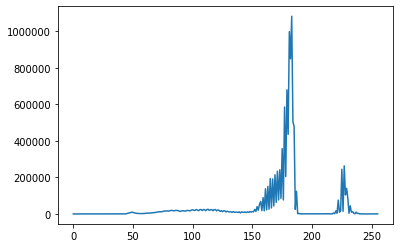

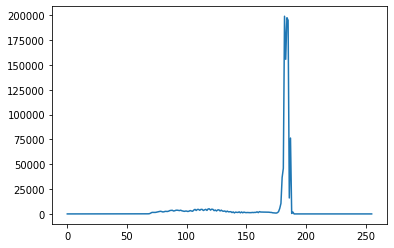

In [42]:
img = cv2.imread('image.jpg', cv2.IMREAD_ANYCOLOR)
print("Image size and shape ", img.size, img.shape)
## Shape=(y,x)

## Update these flags. Currently used to determine some pre/post processing steps
TYPE1_IMAGE=0 #devnagri, thick font, close spaceing horizontal and vertical, less noise
TYPE2_IMAGE=1 #grantha, thin font, curvy, more space horizontal and vertical, noisy

image_type = TYPE1_IMAGE

## Steps 0-4 are preprocessing - nlmeans denoising, bilateral, medianblur, gray scale
img = PreProcessImage(img)

## at this point we have a denoised, smoothened gray scale image. Threshold to get inverted (fg=white) BW image
if (IsLowContrast(img)):
    img = ThresholdSauvola(img)
    showimage(img, 'sauvola-4')
else:
    img = ThresholdWithOTSU(img)
    showimage(img, 'otsu-4')


In [43]:
def getlinewidth(lp):
    ## multiple ways to calculate avg line width. Can take median of h values. Or if variance is high,
    ## can take diff of line positions in that vicinity which will be more accurate?
    lpdiff = np.diff(lp)
    return int(np.sum(lpdiff)/len(lpdiff))

def findlines3(image):
    intensity_hist = cv2.reduce(image, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32S)
    plt.figure(figsize=(10,5))
    plt.plot(intensity_hist)
    plt.xticks(range(0, img.shape[0], int(img.shape[0]/10)))
    plt.xlim([0, img.shape[0]])
    plt.show()

    ## smoothen the intensity histogram using savgol to avoid noise
    x = np.reshape(intensity_hist, len(intensity_hist))
    window_size = int(image.shape[0]/22)  ## magic num!
    if (window_size%2 == 0):
        window_size = window_size+1
    intensity_hist_s = ss.savgol_filter(x, window_size, 5) 
    intensity_hist_s = intensity_hist_s.astype(int)

    plt.figure(figsize=(10,5))
    plt.plot(intensity_hist_s)
    plt.xticks(range(0, img.shape[0], int(img.shape[0]/10)))
    plt.xlim([0, img.shape[0]])
    plt.show()
    
    ## find peaks in smooth plot. Prominence is via observation - if a line has just
    ## a few letters it will create a small peak. We enforce roughly 1/10 of the line
    ## should be occupied with letters
    ## distance is to avoid quirks. We use 5 degree poly to smoothen so it leads to dual
    ## peaks at times close together. Distance specification is a heuristic to avoid
    ## getting too close peaks. Ideally we should skip that, but use this routine recursively
    ## by plugging in the median of linewidths back into the find_peaks as distance till
    ## convergence
    maxval = np.max(intensity_hist_s)
    peaks, _ = ss.find_peaks(intensity_hist_s, prominence=maxval/10, distance=10)
    print('peaks', peaks)
    
    ## trough position is approximated by adding half the inter-peak distance
    b = np.diff(peaks)
    troughs = peaks[:-1] + (b/2).astype(int)  
    np.clip(troughs, 0, img.shape[0])  
    
    linewidth = getlinewidth(troughs)
    ## add estimate of last line. Last peak + half linewidth
    troughs = np.append(troughs, peaks[-1]+int(linewidth/2))
    print(troughs)
    
    plt.figure(figsize=(10,5))
    plt.xticks(range(0, img.shape[0], int(img.shape[0]/10))) 
    plt.xlim([0, img.shape[0]])
    
    plt.plot(intensity_hist)
    plt.plot(peaks, intensity_hist[peaks], "x")
    plt.plot(troughs, intensity_hist[troughs], "o")
    plt.plot(np.zeros_like(intensity_hist), "--", color="gray")
    plt.show()
    
    return troughs, linewidth

In [44]:
img.shape[0]/22

189.13636363636363

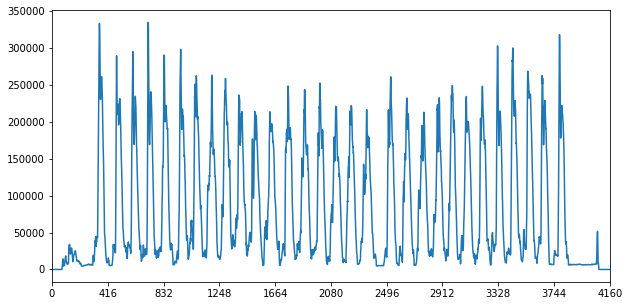

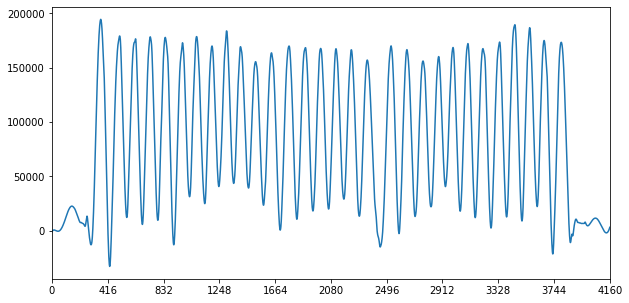

peaks [ 148  364  505  624  733  845  974 1079 1194 1302 1406 1518 1637 1768
 1891 2004 2118 2232 2351 2529 2647 2767 2884 2991 3102 3214 3338 3452
 3562 3670 3798]
[ 256  434  564  678  789  909 1026 1136 1248 1354 1462 1577 1702 1829
 1947 2061 2175 2291 2440 2588 2707 2825 2937 3046 3158 3276 3395 3507
 3616 3734 3857]


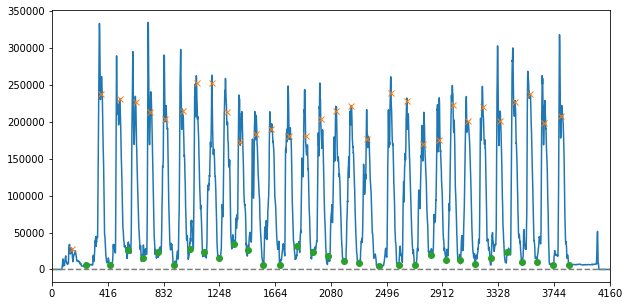

lines 31
linewidth estimate 119


In [45]:
linepositions, linewidth = findlines3(img) 
print('lines', len(linepositions))
np.savetxt("linepositions.csv", linepositions, delimiter=",")
print('linewidth estimate', linewidth)

In [46]:
def FindMargins(img):
    ## TODO if this will benefit from smoothing?
    ## sum intensities along the columns
    sum_cols = cv2.reduce(img, 0, cv2.REDUCE_SUM, dtype=cv2.CV_32S).T
    plt.plot(sum_cols)
    plt.xlim([0, img.shape[1]])
    plt.show()
    
    max_i = np.max(sum_cols)
    lower_range = int(max_i/3)
    upper_range = 2*int(max_i/3)
    mean = np.mean(sum_cols)
    
    leftIndex = 0
    rightIndex = img.shape[1]
    
    for i in range(0, len(sum_cols)):
        if (sum_cols[i]>lower_range):
            leftIndex = i-20
            break;
            
    ## invert the array and find right margin
    for i in range(len(sum_cols)-1, leftIndex, -1):
        if (sum_cols[i]>lower_range):
            rightIndex = i+20
            break
    return leftIndex, rightIndex    

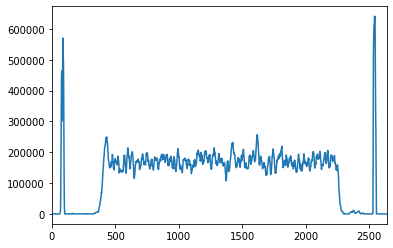

left and right margins 52 2572


In [47]:
lm, rm = FindMargins(img)
print('left and right margins', lm, rm)


In [48]:
def GetContours(image):
    img1 = image.copy()
    showimage(img1, 'contour-input')
    contours, _ = cv2.findContours(img1,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)    
    return contours

def EmitLinesAndRects(lines, rects, oi, bi, rectcolor, linecolor):
    for (i, r) in enumerate(rects):
        cv2.rectangle(oi, (r[0],r[1]), (r[0]+r[2],r[1]+r[3]), rectcolor, 1)
        cv2.rectangle(bi, (r[0],r[1]), (r[0]+r[2],r[1]+r[3]), rectcolor, 1)

    for _, i in enumerate(lines):
        cv2.line(oi, (0,i), (img.shape[1],i), linecolor, 1)
        cv2.line(bi, (0,i), (img.shape[1],i), linecolor, 1)   

def EmitLinesAndConvexHulls(lines, hulls, oi, bi, hullcolor, linecolor):
    cv2.drawContours(oi, hulls, -1, hullcolor, 1)
    cv2.drawContours(bi, hulls, -1, hullcolor, 1)
    
    for _, i in enumerate(lines):
        cv2.line(oi, (0,i), (img.shape[1],i), linecolor, 1)
        cv2.line(bi, (0,i), (img.shape[1],i), linecolor, 1)
    

In [49]:
## Run contouring only on section where lines are detected. This is to avoid:
## a) picking up boundary of image as one giant contour which otherwises forces heirarchical contouring
## b) less postprocessing to pickup contours outside roi

yLower = max(0,int(linepositions[0]-1.3*linewidth))
yUpper = min(img.shape[0],int(linepositions[-1]+0.3*linewidth))

print('mask boundary rows, lower & upper', yLower, yUpper)

maskedImg = img.copy()
## Set regions outside roi to black. Note image is white text on black background
maskedImg[0:yLower, :] = 0
maskedImg[yUpper:img.shape[0], :] = 0
    
contours = GetContours(maskedImg)
print('total contours', len(contours))

boundingrects = []
convexhulls = []

for (i, c) in enumerate(contours):
    # compute bounding box of contour
    r = cv2.boundingRect(c)
    hull = cv2.convexHull(c)
    boundingrects.append(r)
    convexhulls.append(hull) 

mask boundary rows, lower & upper 101 3892
total contours 669


In [50]:
def GetImageForConvexHull(hull):
    # create a blank image of size w,h. br is (x,y,w,h)
    ### absolute coordinates cause an issue with hull rendering.
    mask = np.zeros(img.shape, np.uint8)
    cv2.drawContours(mask,[hull],-1,(255,255,255),-1)
    mask = cv2.bitwise_and(img, img, mask=mask)
    return mask
    
def BreakMergedCharsViaHull(mask, rect, output):
    # split image approx around mid point where intensity projection is weakest
    hist = cv2.reduce(mask, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32S)
    #plt.plot(hist)
    #plt.xlim([0, mask.shape[0]])
    #plt.show()
    
    max_y = np.max(hist)
    (x,y,w,h) = rect
    # some sensible default
    currentmin = max_y
    currentminindex = y + int(h/2)
    
    # first y rows should be empty, hull starts around y'th row
    # look for minima in the 35-65% band in the middle
    #print('checking histogram range y, y+h', y, y+h)
    for i in range(y, y+h):
        if (i>0.35*h+y and i<0.65*h+y):
            ## if intensity is below average start tracking
            if (hist[i]<currentmin):
                currentmin = hist[i]
                currentminindex = i
                # print('updating minindex to', i)
    
    # print('x,y,currentminindex,h,w', x,y,currentminindex,h,w)
    
    # now redo contouring in each subpart and report the bounding rectangles.
    mask1 = mask.copy()
    mask2 = mask.copy()
    
    mask1[currentminindex:y+h, x:x+w]=0
    mask2[0:currentminindex, x:x+w]=0
    # showimage(mask1)
    # showimage(mask2)
    
    c1,_ = cv2.findContours(mask1,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE);
    c2,_ = cv2.findContours(mask2,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE);
    for (_, c) in enumerate(c1):
        # compute bounding box of contour
        # print('upper contour', c)
        r = cv2.boundingRect(c)
        output.append(r)
        # print('upper broken rect', r)
    for (_, c) in enumerate(c2):
        # compute bounding box of contour
        # print('lower contour', c)
        r = cv2.boundingRect(c)
        output.append(r)
        # print('lower broken rect', r)

In [51]:
def boundcheck(rect, line, prevline, linewidth):
    ## rectangle bounds are (x,y) (x+w, y+h). Rect is x,y,w,h. If y+h is less than line & greater than line-1
    if (prevline is None):
        prevline = line-linewidth
    
    if (rect[1]<prevline-0.3*linewidth):
        #print('Skipping rect because it starts before previous line', rect, line)
        return False
    if (rect[1]>line):
        #print('Skipping rect because it starts after line', rect, line)
        return False
    
    if (rect[1]+rect[3] <= line):
        #print('Adding rect because it is between line and prevline:', rect, line, prevline)
        return True
    elif (rect[1]+rect[3] > line and (rect[1]+rect[3] < line+0.3*linewidth)):
        #print('Adding rect because it starts above line:', rect, line)
        return True
    
    return False

def ShowBoundingRects(cbr, oi, title):
    for (j, r) in enumerate(cbr):
        cv2.rectangle(oi, (r[0],r[1]), (r[0]+r[2],r[1]+r[3]), (255,0,255), 1)
    showimage(oi, title)
    
def GetImageForRect(r):
    # get region from image to break. [y:y+h,x:x+w]
    roi = img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]]
    return roi

In [52]:
def PreProcessBoundingRects1(boundingrects, convexhulls, linewidth):
    br = boundingrects.copy()
    simpleboundingrects = []
    compoundboundingrects = []
    discardedboundingrects = []
    
    for (i, rect) in enumerate(br):
        #h is rect[3]
        if (rect[3]/linewidth < 1.2):
            simpleboundingrects.append(rect)
        elif (rect[3] <= 2.4*linewidth):
            compoundboundingrects.append(rect)
        else:
            print('discarding large rect', rect)
            discardedboundingrects.append(rect)
            
    s = len(simpleboundingrects)
    c = len(compoundboundingrects)
    d = len(discardedboundingrects)
    print('# simple rects', s)
    print('# compound rects', c)
    print('# discarded large rects', d)
    
    oi = cv2.imread('image.jpg', cv2.IMREAD_ANYCOLOR)
    ShowBoundingRects(compoundboundingrects, oi, 'compound-bounding-rects')
    
    # refactor this to call either routine. Break out splitmultiline into its own function
    # process the problem rects this way
    # erode the rect contents till it splits in two (or more) vertical rects
    output = []
    for (_, r) in enumerate(compoundboundingrects):
        # Hull break method
        index = boundingrects.index(r)
        hull = convexhulls[index]
        # print('compound char rect & hull:', r, hull)
        mask = GetImageForConvexHull(hull)
        # showimage(mask)
        BreakMergedCharsViaHull(mask, r, output)
        #print('broken rects len', len(output))
        
    oi = cv2.imread('image.jpg', cv2.IMREAD_ANYCOLOR)
    ShowBoundingRects(output, oi, 'compound-rects-broken')
    
    for (_, r) in enumerate(output):
        simpleboundingrects.append(r)
    return simpleboundingrects, s, c, d

def contains(r1, r2):
    if (r1 != r2):
        return r1[0] <= r2[0] and r2[0]+r2[2] <= r1[0]+r1[2] and r1[1] <= r2[1] and r2[1]+r2[3] <= r1[1]+r1[3]
    return False
    
def PreProcessBoundingRects2(boundingrects):
    areas = []
    br = []
    for (_, small) in enumerate(boundingrects):
        a = small[2]*small[3]
        areas.append(a)
        if (a>4):
            # check this is not contained fully in another other rect
            contained = False
            for (_, big) in enumerate(boundingrects):
                if contains(big,small):
                    contained = True
                    break
            if (contained == False):
                br.append(small)
            #else:
            #    print('small contained in big', small, big)
        #else:
            #print('too small', small)
            
    np.savetxt("boundingrectsAreas.csv", areas, fmt="%s", delimiter=",")
    return br;

def ShouldMerge(r1, r2):
    ## need additional criteria here. e.g. overlap with a narrow vertical or horizontal char should be ok.
    a1 = r1[2]*r1[3]
    a2 = r2[2]*r2[3]
    
    xOverlap = (r1[0]<=r2[0] and r1[0]+r1[2]>=r2[0]) or (r1[0]>=r2[0] and r1[0]<=r2[0]+r2[2])
    yOverlap = (r1[1]<=r2[1] and r1[1]+r1[3]>=r2[1]) or (r1[1]>=r2[1] and r1[1]<=r2[1]+r2[3])
    y_r1_CloseAbove_r2 = r2[1]>r1[1]+r1[3] and r2[1]<r1[1]+r1[3]+int(0.3*linewidth)
    y_r1_CloseBelow_r2 = r1[1]>r2[1]+r2[3] and r1[1]<r2[1]+r2[3]+int(0.3*linewidth)
    yCloseEnough = y_r1_CloseAbove_r2 or y_r1_CloseBelow_r2
    
    #if (xOverlap and yOverlap):
    #    print('r1 overlap r2', r1, r2)
    #if (xOverlap and yOverlap==False and y_r1_CloseAbove_r2):
    #    print('r1 close above r2', r1, r2)
    #if (xOverlap and yOverlap==False and y_r1_CloseBelow_r2):
    #    print('r1 close below r2', r1, r2)
    
    ## merge only large left r1 with small right r2, this simplifies bookkeeping at expense of some more iterations
    ## character height vs linewidth is a heuristic. If one of the characters has height less than 0.3 of line width
    ## consider merging. If the lines are quite apart then median char height could be used instead.
    if (xOverlap and (yOverlap or yCloseEnough)):
        #if (a1/a2 >2):
        if (r1[3]<=int(0.3*linewidth) or r2[3]<=int(0.3*linewidth)):
            ## on the same line x overlap is enough to merge. On the top line add a qualifier for y overlap
            #print('a1/a2>2', r1, r2)
            return True
        else:
            ## rectangles are closer in size. Proceed carefully. Merge in vertical is safer than merge in horizontal
            ## 1) if extent of x overlap is close to r2 width, merge r2 into r1. r2 is to right of r1. This is either
            ##    vertical stack case or matras that are narrow slivers to the right. 
            ## 2) if extent of y overlap is fully above or below the center line of r1. r2 is to right of r1. This is 
            ##    some parts of r1 are fragmented and to the right
            if (r2[0]>=r1[0]):
                overlap = min(r2[0]+r2[2], r1[0]+r1[2])-max(r1[0], r2[0])
                if (overlap > int(0.8*r2[2])):
                    print('r2 significant overlap with r1', r1, r2, overlap)
                    return True
                if ((r2[1]>r1[1]+int(0.5*r1[3])) and r2[1]<r1[1]+r1[3]):
                    ## r2 is between middle and bottom of r1  |=
                    print('r2 more than midway down r1', r1, r2)
                    return True
                if ((r1[1]>r2[1]+int(0.5*r2[3])) and r1[1]<r2[1]+r2[3]):
                    ## r1 is between middle and bottom of r2 =|
                    print('r1 more than midsway down r2', r1, r2)
                    return True
        #else:
        #    print('r1 not bigger than r2 to right, no merge', r1, r2)
    return False
    
def PreProcessBR3(linerects):
    ## call the recursive routine few times. Because merging can create more overlaps instead of complicated
    ## logic just run this routine multiple times and it should result in convergence till count doesnt decrease
    dr = []
    currentLineRects = linerects.copy()
    
    for i in range(1,3):
        print('merge iteration', i)
        currentLineRects = PreProcessBoundingRects3(currentLineRects, dr)
        
    return currentLineRects

def PreProcessBoundingRects3(linerects, discardedrects=[]):
    ## find overlapped rectangles in a line and see if they can be merged
    ## There are two conditions:
    ## 1) There must be an overlap or touching of borders. Look in window of 5 rects before/after
    ## 2) The areas of rectangles must be dissimilar. Current magic ratio is 2
    
    mergeOccurred = False
    mergedlinerects = []
    
    for (i, r1) in enumerate(linerects):
            
        if (r1 in discardedrects):
            continue
        lookback=max(0,i-5)
        lookahead=min(i+5,len(linerects))
        for (j, r2) in enumerate(linerects[lookback:lookahead]):
            
                
            if (r1 == r2):
                continue
            if (r2 in discardedrects):
                continue
            
            #print('checking r1 and r2', r1, r2)
            if (ShouldMerge(r1, r2)):
                #print('merging r1 and r2', r1, r2)
                x1 = min(r1[0], r2[0])
                y1 = min(r1[1], r2[1]) 
                x2 = max(r1[0]+r1[2], r2[0]+r2[2])
                y2 = max(r1[1]+r1[3], r2[1]+r2[3])
                w = x2-x1
                h = y2-y1
                r1 = (x1,y1,w,h)
                #print('merged **r1** and r2', r1, r2)
                mergeOccurred = True
                discardedrects.append(r2)
            #else:
             #   print('r1 r2 dont satisfy criteria for merge', r1, r2)
            
        # at end of inner loop, r1 didnt overlap, or it did and has new values. Either way add to output
        mergedlinerects.append(r1)
    
    ## debug
    #print('new series:', mergedlinerects)
    #print('discarded series', discardedrects)
    
    if (mergeOccurred):
        #print('atleast one merge happened, processing again')
        mergedlinerects = PreProcessBoundingRects3(mergedlinerects, discardedrects)
        
    #print('merged rects', mergedlinerects)
    #print('discarded rects', discardedrects)
    return mergedlinerects


def PostProcessBoundingRects4(linerects, linewidth):
    ## after all processing remove rects that dont have good content, or are outside the left/right margins
    ## for now remove rects with very skewed aspect ratio
    updatedlinerects=[]
    
    for (i, rc) in enumerate(linerects):
        outputline = []
        for (j, r) in enumerate(rc):
            if (r[0]+r[2]<lm or r[0]>rm):
                print('removing rectange outside margins', r)
                continue
                
            if (r[3]>int(linewidth/5) or r[2]<4*r[3]):
                if (r[2]>5 and r[3]>5):
                    outputline.append(r)
                else:
                    print('removing very small rect', r)
            else:
                print('removing junk content rectange', r)
                
        updatedlinerects.append(outputline)
    return updatedlinerects
                

                    

def ArrangeLineByLine(boundingrects, linepositions):
    splitchars = []
    br = boundingrects.copy()
    
    for (i, l) in enumerate(linepositions):
        charsinline = []
        ##split bounding rects by linepos
        if (i==0):
            for (j, rect) in enumerate(br):
                if (boundcheck(rect, linepositions[0], None, linewidth)):
                    charsinline.append(rect)
        else:
            for (j, rect) in enumerate(br):
                if (boundcheck(rect, linepositions[i], linepositions[i-1], linewidth)):
                    charsinline.append(rect)
                    
        # remove the rects that got assigned to that line
        br = [x for x in br if x not in charsinline]
        
        #print('#rects left after line', len(br), i)
        # append sorted by x position
        charsinline.sort(key = lambda x: x[0]) 
        splitchars.append(charsinline)
        print('chars by line:', i, len(charsinline))
    
        
    if (len(br)>0):
        # leftovers?
        #leftovers = []
        #for (j, rect) in enumerate(br):
        #    leftovers.append(rect)
        #splitchars.append(leftovers)
        print('chars with indeterminate line:', len(br))
    
    return splitchars, br

In [53]:
# split any rect spanning lines into smaller rects
br, s, c, d = PreProcessBoundingRects1(boundingrects, convexhulls, linewidth)

# remove very small rects or fully contained in another
br = PreProcessBoundingRects2(br)

oi1 = cv2.imread('image.jpg', cv2.IMREAD_ANYCOLOR)
bi1 = oi1.copy()
bi1[:,:,:] = 255

EmitLinesAndRects(linepositions, br, oi1, bi1, (255,0,0), (0,255,0))
showimage(oi1, 'lines-rects')
showimage(bi1, 'only-lines-rects')

oi2 = cv2.imread('image.jpg', cv2.IMREAD_ANYCOLOR)
bi2 = oi2.copy()
bi2[:,:,:] = 255
EmitLinesAndConvexHulls(linepositions, convexhulls, oi2, bi2, (255,0,0), (0,255,0))
showimage(oi2, 'lines-hulls')
showimage(bi2, 'only-lines-hulls')

linerects, uncertainchars = ArrangeLineByLine(br, linepositions)

## merge certain rectangles after line numbering assigned
updatedlinerects = []
for _,lr in enumerate(linerects):
    mergedlr = PreProcessBR3(lr)
    updatedlinerects.append(mergedlr)

## final cleanup to trim rects with skewed aspect ratio or lying outside margins
updatedlinerects = PostProcessBoundingRects4(updatedlinerects, linewidth)
      
oi3 = cv2.imread('image.jpg', cv2.IMREAD_ANYCOLOR)
bi3 = oi3.copy()
bi3[:,:,:]=255

numchar = 0
for (i, rc) in enumerate(updatedlinerects):
    for (j, r) in enumerate(rc):
        cv2.rectangle(oi3, (r[0],r[1]), (r[0]+r[2],r[1]+r[3]), ((i%2)*255,((i+1)%2)*255,0), 1)
        cv2.rectangle(bi3, (r[0],r[1]), (r[0]+r[2],r[1]+r[3]), ((i%2)*255,((i+1)%2)*255,0), 1)
        numchar = numchar+1
                      
for (k, r) in enumerate(uncertainchars):
    cv2.rectangle(bi3, (r[0],r[1]), (r[0]+r[2],r[1]+r[3]), (0,0,255), 1)

for _, i in enumerate(linepositions):
    cv2.line(oi3, (0,i), (img.shape[1],i), (127,0,127), 1)
    cv2.line(bi3, (0,i), (img.shape[1],i), (127,0,127), 1)

print('Stats:Contours {0}, good rects {1}, compound rects {2}, discarded rects {3}, chars {4}, dropped chars {5}'\
      .format(len(contours), s, c, d, numchar, len(uncertainchars)))
showimage(oi3, 'final')
showimage(bi3, 'final-rects')

## This prints the bounding rect coordinates. 2D array so csv print needs some more parsing.
np.savetxt("boundingrects.csv", updatedlinerects, fmt="%s", delimiter=",")
os.chdir(cwd)

discarding large rect (2529, 101, 26, 3791)
discarding large rect (69, 101, 34, 3791)
# simple rects 667
# compound rects 0
# discarded large rects 2
chars by line: 0 5
chars by line: 1 14
chars by line: 2 25
chars by line: 3 22
chars by line: 4 19
chars by line: 5 23
chars by line: 6 20
chars by line: 7 20
chars by line: 8 24
chars by line: 9 19
chars by line: 10 22
chars by line: 11 22
chars by line: 12 18
chars by line: 13 19
chars by line: 14 22
chars by line: 15 18
chars by line: 16 16
chars by line: 17 24
chars by line: 18 24
chars by line: 19 24
chars by line: 20 24
chars by line: 21 28
chars by line: 22 22
chars by line: 23 17
chars by line: 24 25
chars by line: 25 23
chars by line: 26 22
chars by line: 27 18
chars by line: 28 21
chars by line: 29 20
chars by line: 30 19
chars with indeterminate line: 1
merge iteration 1
merge iteration 2
merge iteration 1
merge iteration 2
merge iteration 1
r2 significant overlap with r1 (2113, 477, 119, 43) (2152, 479, 80, 41) 80
r2 significa

In [ ]:
## random stuff after this

oi = cv2.imread('image.jpg', cv2.IMREAD_ANYCOLOR)
# save 1st, 5,6,7th chars of line 1 in separate files
line1 = linerects[0]
(x,y,w,h) = line1[1]

char1 = oi[y:y+h,x:x+w]
cv2.imwrite('char1.jpg', char1)

(x,y,w,h) = line1[14]
char14 = oi[y:y+h,x:x+w]
cv2.imwrite('char14.jpg', char14)

(x,y,w,h) = line1[15]
char15 = oi[y:y+h,x:x+w]
cv2.imwrite('char15.jpg', char15)

(x,y,w,h) = line1[16]
char16 = oi[y:y+h,x:x+w]
cv2.imwrite('char16.jpg', char16)

In [ ]:
line1


In [ ]:
##kernel = np.ones((2,2), np.uint8)
##imgerode = cv2.imread('..\ImageData1\image.jpg', cv2.IMREAD_GRAYSCALE)
##blur = cv2.GaussianBlur(imgerode, (3,3), 0)
##ret, adtimage = cv2.threshold(blur, 115, 255, cv2.THRESH_BINARY_INV)
##img_erosion = cv2.erode(adtimage, kernel, iterations=1) 
##cv2.imwrite('erodedimage.jpg', img_erosion)

##blankimgeroded = cv2.imread('..\ImageData1\image.jpg', cv2.IMREAD_ANYCOLOR)
##blankimgeroded[:,:,:] = 255
##contours, _ = cv2.findContours(img_erosion,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
##for (i, c) in enumerate(contours):
    # compute bounding box of contour
##    (x, y, w, h) = cv2.boundingRect(c)
##    cv2.rectangle(blankimgeroded, (x,y), (x+w,y+h), (255,0,0), 1)
    




In [ ]:
def showrowhistsobel(img):
    # blur and invert
    img2 = img.copy()
    height, width = img.shape[:2]
    blur2 = cv2.GaussianBlur(img2, (3,3), 0)
    _, img2 = cv2.threshold(blur2, otsu_threshold, 255, cv2.THRESH_BINARY)
    showimage(img2)
    
    #take sobel for top edge, find shirorekha
    #img2 = cv2.Sobel(img2, ddepth=1, dx=0, dy=1, ksize=3, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)
    img2 = cv2.Sobel(img2, ddepth=-1, dx=0, dy=1, ksize=3)
    showimage(img2)
    
    # now take row histogram
    ## rowwise sum, should return a column of height #rows, with each entry being sum of pixel
    ## intensities
    sum_x = cv2.reduce(img2, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32S)
    plt.plot(sum_x)
    plt.xlim([0, height])
    plt.show()
    return sum_x
    

# sobel method gets good approx to shirorekha but troughs between peaks have FP. Can come to this later
print(otsu_threshold)
peakdata = showrowhistsobel(img)
#peakdata = showrowhist(img)
